# 使用NAD算法提升模型安全性

[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/r1.7/docs/notebook/mindspore_improve_model_security_nad.ipynb)

## 概述

本教程介绍MindArmour提供的模型安全防护手段，引导您快速使用MindArmour，为您的AI模型提供一定的安全防护能力。

AI算法设计之初普遍未考虑相关的安全威胁，使得AI算法的判断结果容易被恶意攻击者影响，导致AI系统判断失准。攻击者在原始样本处加入人类不易察觉的微小扰动，导致深度学习模型误判，称为对抗样本攻击。MindArmour模型安全提供对抗样本生成、对抗样本检测、模型防御、攻防效果评估等功能，为AI模型安全研究和AI应用安全提供重要支撑。

- 对抗样本生成模块支持安全工程师快速高效地生成对抗样本，用于攻击AI模型。

- 对抗样本检测、防御模块支持用户检测过滤对抗样本、增强AI模型对于对抗样本的鲁棒性。

- 评估模块提供多种指标全面评估对抗样本攻防性能。

这里通过图像分类任务上的对抗性攻防，以攻击算法FGSM和防御算法NAD为例，介绍MindArmour在对抗攻防上的使用方法。

> 本例面向CPU、GPU、Ascend 910 AI处理器，你可以在这里下载完整的样例代码： https://gitee.com/mindspore/mindarmour/blob/r1.7/examples/model_security/model_defenses/mnist_defense_nad.py

## 准备工作

本例采用LeNet5网络进行示例，将展示训练后的模型，正常验证的结果如何，使用对抗样本后的验证效果如何，在完成上述情况前，需做如下准备。

1. 下载安装跟MindSpore版本对应的MindArmour安装包。

In [1]:
import os
import mindspore

version = mindspore.__version__
ma_link = "https://ms-release.obs.cn-north-4.myhuaweicloud.com/{0}/MindArmour/x86_64/mindarmour-{0}-cp37-cp37m-linux_x86_64.whl".format(version)
os.system("pip install {}".format(ma_link))

256

2. 准备MNIST数据集。

以下示例代码将数据集下载并解压到指定位置。

In [ ]:
import os
import requests

requests.packages.urllib3.disable_warnings()

def download_dataset(dataset_url, path):
    filename = dataset_url.split("/")[-1]
    save_path = os.path.join(path, filename)
    if os.path.exists(save_path):
        return
    if not os.path.exists(path):
        os.makedirs(path)
    res = requests.get(dataset_url, stream=True, verify=False)
    with open(save_path, "wb") as f:
        for chunk in res.iter_content(chunk_size=512):
            if chunk:
                f.write(chunk)
    print("The {} file is downloaded and saved in the path {} after processing".format(os.path.basename(dataset_url), path))

train_path = "datasets/MNIST_Data/train"
test_path = "datasets/MNIST_Data/test"

download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte", train_path)
download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte", train_path)
download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-labels-idx1-ubyte", test_path)
download_dataset("https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-images-idx3-ubyte", test_path)

下载的数据集文件的目录结构如下：

```text
./datasets/MNIST_Data
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```

## 建立被攻击模型

以MNIST为示范数据集，自定义的简单模型作为被攻击模型。

### 引入相关包

In [3]:
import os
import numpy as np
from scipy.special import softmax

from mindspore import dataset as ds
from mindspore import dtype as mstype
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
import mindspore.nn as nn
from mindspore.nn import SoftmaxCrossEntropyWithLogits
from mindspore import Model, Tensor, context
from mindspore.train.callback import LossMonitor

from mindarmour.adv_robustness.attacks import FastGradientSignMethod
from mindarmour.utils import LogUtil
from mindarmour.adv_robustness.evaluations import AttackEvaluate

context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

LOGGER = LogUtil.get_instance()
LOGGER.set_level("INFO")
TAG = 'demo'

### 加载数据集

利用MindSpore的dataset提供的MnistDataset接口加载MNIST数据集。

In [4]:
# generate dataset for train of test
def generate_mnist_dataset(data_path, batch_size=32, repeat_size=1,
                           num_parallel_workers=1, index=True):
    """
    create dataset for training or testing
    """
    # define dataset
    ds1 = ds.MnistDataset(data_path)

    # define operation parameters
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0

    # define map operations
    resize_op = CV.Resize((resize_height, resize_width),
                          interpolation=Inter.LINEAR)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # apply map operations on images
    if not index:
        one_hot_enco = C.OneHot(10)
        ds1 = ds1.map(operations=one_hot_enco, input_columns="label",
                      num_parallel_workers=num_parallel_workers)
        type_cast_op = C.TypeCast(mstype.float32)

    ds1 = ds1.map(operations=type_cast_op, input_columns="label",
                  num_parallel_workers=num_parallel_workers)
    ds1 = ds1.map(operations=resize_op, input_columns="image",
                  num_parallel_workers=num_parallel_workers)
    ds1 = ds1.map(operations=rescale_op, input_columns="image",
                  num_parallel_workers=num_parallel_workers)
    ds1 = ds1.map(operations=hwc2chw_op, input_columns="image",
                  num_parallel_workers=num_parallel_workers)

    # apply DatasetOps
    buffer_size = 10000
    ds1 = ds1.shuffle(buffer_size=buffer_size)
    ds1 = ds1.batch(batch_size, drop_remainder=True)
    ds1 = ds1.repeat(repeat_size)

    return ds1

### 建立模型

这里以LeNet模型为例，您也可以建立训练自己的模型。

1. 定义LeNet模型网络。

In [5]:
import mindspore.nn as nn
from mindspore.common.initializer import Normal

class LeNet5(nn.Cell):
    """Lenet network structure."""
    # define the operator required
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.max_pool2d(self.relu(self.conv1(x)))
        x = self.max_pool2d(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

2. 训练LeNet模型。利用上面定义的数据加载函数`generate_mnist_dataset`载入数据。

In [6]:
mnist_path = "./datasets/MNIST_Data/"
batch_size = 32
# train original model
ds_train = generate_mnist_dataset(os.path.join(mnist_path, "train"),
                                  batch_size=batch_size, repeat_size=1,
                                  index=False)
net = LeNet5()
loss = SoftmaxCrossEntropyWithLogits(sparse=False, reduction="mean")
opt = nn.Momentum(net.trainable_params(), 0.01, 0.9)
model = Model(net, loss, opt, metrics=None)
model.train(3, ds_train, callbacks=[LossMonitor(1875)],
            dataset_sink_mode=False)

epoch: 1 step: 1875, loss is 2.3040888
epoch: 2 step: 1875, loss is 0.29309553
epoch: 3 step: 1875, loss is 0.19545117


3. 测试模型

In [7]:
# prediction accuracy before attack

# get test data
ds_test = generate_mnist_dataset(os.path.join(mnist_path, "test"),
                                 batch_size=batch_size, repeat_size=1,
                                 index=False)
inputs = []
labels = []
for data in ds_test.create_tuple_iterator():
    inputs.append(data[0].asnumpy().astype(np.float32))
    labels.append(data[1].asnumpy())

test_inputs = np.concatenate(inputs)
test_labels = np.concatenate(labels)

def get_net_acc(network, inputs_data, labels):
    network.set_train(False)
    test_logits = net(Tensor(inputs_data)).asnumpy()
    tmp = np.argmax(test_logits, axis=1) == np.argmax(labels, axis=1)
    accuracy = np.mean(tmp)
    return accuracy

accuracy = get_net_acc(net, test_inputs, test_labels)
LOGGER.info(TAG, 'prediction accuracy before attacking is : %s', accuracy)

[INFO] MA(22790:140157538080576,MainProcess):2021-04-07 15:35:15,249 [<ipython-input-7-04c3ee7c4eeb>:24] [demo] prediction accuracy before attacking is : 0.9779647435897436


测试结果中分类精度达到了97%以上。

## 对抗性攻击

在进行对抗性攻击前，选取32张图片查看，没有攻击前的图片展示的效果如何。

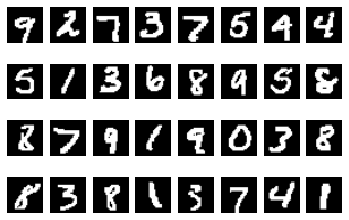

In [8]:
import matplotlib.pyplot as plt

count = 1
%matplotlib inline
for i in test_inputs[:32]:
    plt.subplot(4, 8, count)
    plt.imshow(np.squeeze(i), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.axis("off")
    count += 1
plt.show()

调用MindArmour提供的FGSM接口（FastGradientSignMethod），对验证的图片数据进行对抗性攻击。

查看之前选取的32张图片，对抗性攻击后，图片产生了什么变化。

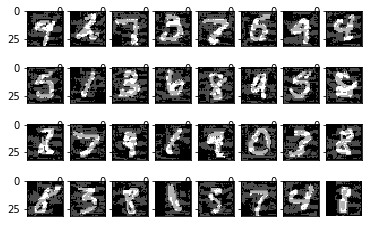

In [9]:
# attacking
# get adv data
attack = FastGradientSignMethod(net, eps=0.3, loss_fn=loss)
adv_data = attack.batch_generate(test_inputs, test_labels)

count = 1
%matplotlib inline
for i in adv_data[:32]:
    plt.subplot(4, 8, count)
    plt.imshow(np.squeeze(i), cmap='gray', interpolation='nearest')
    plt.xticks([])
    count += 1

plt.axis("off")
plt.show()

受到攻击后，图片出现了很多的类似水印的背景，但是在视觉上还是能明显地分辨出来图片是什么，但是对于模型来说，可能不一定。

接下来，验证模型在攻击后的图片分类能力。

In [10]:
# get accuracy of adv data on original model
adv_logits = net(Tensor(adv_data)).asnumpy()
adv_proba = softmax(adv_logits, axis=1)
tmp = np.argmax(adv_proba, axis=1) == np.argmax(test_labels, axis=1)
accuracy_adv = np.mean(tmp)
LOGGER.info(TAG, 'prediction accuracy after attacking is : %s', accuracy_adv)
attack_evaluate = AttackEvaluate(test_inputs.transpose(0, 2, 3, 1),
                                 test_labels,
                                 adv_data.transpose(0, 2, 3, 1),
                                 adv_proba)
LOGGER.info(TAG, 'mis-classification rate of adversaries is : %s',
            attack_evaluate.mis_classification_rate())
LOGGER.info(TAG, 'The average confidence of adversarial class is : %s',
            attack_evaluate.avg_conf_adv_class())
LOGGER.info(TAG, 'The average confidence of true class is : %s',
            attack_evaluate.avg_conf_true_class())
LOGGER.info(TAG, 'The average distance (l0, l2, linf) between original '
            'samples and adversarial samples are: %s',
            attack_evaluate.avg_lp_distance())
LOGGER.info(TAG, 'The average structural similarity between original '
            'samples and adversarial samples are: %s',
            attack_evaluate.avg_ssim())

[INFO] MA(22790:140157538080576,MainProcess):2021-04-07 15:35:17,892 [<ipython-input-10-b5401939add9>:6] [demo] prediction accuracy after attacking is : 0.045072115384615384
[INFO] MA(22790:140157538080576,MainProcess):2021-04-07 15:35:17,926 [<ipython-input-10-b5401939add9>:12] [demo] mis-classification rate of adversaries is : 0.9549278846153846
[INFO] MA(22790:140157538080576,MainProcess):2021-04-07 15:35:17,926 [<ipython-input-10-b5401939add9>:14] [demo] The average confidence of adversarial class is : 0.70117253
[INFO] MA(22790:140157538080576,MainProcess):2021-04-07 15:35:17,927 [<ipython-input-10-b5401939add9>:16] [demo] The average confidence of true class is : 0.04269705
[INFO] MA(22790:140157538080576,MainProcess):2021-04-07 15:35:18,667 [<ipython-input-10-b5401939add9>:19] [demo] The average distance (l0, l2, linf) between original samples and adversarial samples are: (2.2191764481915106, 0.5356972896720278, 0.3000000376345752)
[INFO] MA(22790:140157538080576,MainProcess):20

对模型进行FGSM无目标攻击后：

- 模型精度由97%以上降到不足10%；

- 误分类率超过90%，成功攻击的对抗样本的预测类别的平均置信度（ACAC）为 0.70117253；

- 成功攻击的对抗样本的真实类别的平均置信度（ACTC）为 0.04269705；

- 同时给出了生成的对抗样本与原始样本的零范数距离、二范数距离和无穷范数距离，平均每个对抗样本与原始样本间的结构相似性为0.5092086；

- 平均每生成一张对抗样本所需时间为0.003125s。

FGSM无目标攻击后生成的对抗样本。从视觉角度而言，几乎没有明显变化，但是均成功误导了模型，使模型将其误分类为其他非正确类别。

## 对抗性防御

NaturalAdversarialDefense（NAD）是一种简单有效的对抗样本防御方法，使用对抗训练的方式，在模型训练的过程中构建对抗样本，并将对抗样本与原始样本混合，一起训练模型。随着训练次数的增加，模型在训练的过程中提升对于对抗样本的鲁棒性。NAD算法使用FGSM作为攻击算法，构建对抗样本。

### 防御实现

调用MindArmour提供的NAD防御接口（NaturalAdversarialDefense）。

In [11]:
from mindarmour.adv_robustness.defenses import NaturalAdversarialDefense

# defense
net.set_train()
nad = NaturalAdversarialDefense(net, loss_fn=loss, optimizer=opt,
                                bounds=(0.0, 1.0), eps=0.3)
nad.batch_defense(test_inputs, test_labels, batch_size=32, epochs=10)

# get accuracy of test data on defensed model
net.set_train(False)
test_logits = net(Tensor(test_inputs)).asnumpy()

tmp = np.argmax(test_logits, axis=1) == np.argmax(test_labels, axis=1)
accuracy = np.mean(tmp)
LOGGER.info(TAG, 'accuracy of TEST data on defensed model is : %s', accuracy)

# get accuracy of adv data on defensed model
adv_logits = net(Tensor(adv_data)).asnumpy()
adv_proba = softmax(adv_logits, axis=1)
tmp = np.argmax(adv_proba, axis=1) == np.argmax(test_labels, axis=1)
accuracy_adv = np.mean(tmp)

attack_evaluate = AttackEvaluate(test_inputs.transpose(0, 2, 3, 1),
                                 test_labels,
                                 adv_data.transpose(0, 2, 3, 1),
                                 adv_proba)

LOGGER.info(TAG, 'accuracy of adv data on defensed model is : %s',
            np.mean(accuracy_adv))
LOGGER.info(TAG, 'defense mis-classification rate of adversaries is : %s',
            attack_evaluate.mis_classification_rate())
LOGGER.info(TAG, 'The average confidence of adversarial class is : %s',
            attack_evaluate.avg_conf_adv_class())
LOGGER.info(TAG, 'The average confidence of true class is : %s',
            attack_evaluate.avg_conf_true_class())

[INFO] MA(22790:140157538080576,MainProcess):2021-04-07 15:35:31,896 [<ipython-input-11-2b02004977b6>:15] [demo] accuracy of TEST data on defensed model is : 0.9793669871794872
[INFO] MA(22790:140157538080576,MainProcess):2021-04-07 15:35:32,001 [<ipython-input-11-2b02004977b6>:29] [demo] accuracy of adv data on defensed model is : 0.7190504807692307
[INFO] MA(22790:140157538080576,MainProcess):2021-04-07 15:35:32,002 [<ipython-input-11-2b02004977b6>:31] [demo] defense mis-classification rate of adversaries is : 0.2809495192307692
[INFO] MA(22790:140157538080576,MainProcess):2021-04-07 15:35:32,003 [<ipython-input-11-2b02004977b6>:33] [demo] The average confidence of adversarial class is : 0.5715536
[INFO] MA(22790:140157538080576,MainProcess):2021-04-07 15:35:32,004 [<ipython-input-11-2b02004977b6>:35] [demo] The average confidence of true class is : 0.16227658


### 防御效果

使用NAD进行对抗样本防御后，模型对于对抗样本的误分类率从90%以上降至不足30%，模型有效地防御了对抗样本。同时，模型对于原来测试数据集的分类精度达97%。